In [1]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

2024-08-29 19:46:02.935562: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 19:46:02.943685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 19:46:02.952038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 19:46:02.954593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 19:46:02.961781: I tensorflow/core/platform/cpu_feature_guar

In [2]:
create_experiment_snapshots([25, 50, 75, 100])

In [3]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = [100]
network_size = [25]
total_nodes = 300
new_network = True
model = "AI_model/models_joo_kai/main_network_parameter_set_1.h5"
trial = 5

mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RadarPlot:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.model = model
        self.trial = trial
        
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]
        self.mtd_interval = mtd_interval
        self.network_size = network_size
        self.normalization_values = self.get_scheme_values('nomtd')




    def get_scheme_values(self, scheme):
        # Simulate and stack nomtd DataFrames
        dfs = []
        for _ in range(self.trial):
            if scheme == 'nomtd':
                mtd = pd.DataFrame(single_mtd_simulation("no_mtd", [None], checkpoint=list(np.arange(0.01, 1.01, 0.01)), 
                                                         mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
            elif scheme == 'mtd_ai':
                try:
                    mtd = pd.DataFrame(mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network, 
                                                             mtd_interval=self.mtd_interval,network_size=self.network_size )).drop('Name', axis=1)
                    # mtd = pd.DataFrame(mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network, 
                    #                                         mtd_interval=self.mtd_interval,network_size=self.network_size ))
                    
                except:
                    continue

                
            else:
                mtd = pd.DataFrame(specific_multiple_mtd_simulation(scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
                
            dfs.append(mtd)
        stacked_nomtd = pd.concat(dfs, ignore_index=True)
        # Calculate median for normalization
        median_df = stacked_nomtd.groupby(['mtd_interval', 'network_size']).median().loc[self.mtd_interval[0],self.network_size[0]].to_dict()

        return median_df

    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {"MEF"}  
        metrics_to_minimize = {'host_compromise_ratio', 'time_to_compromise', 'attack_path_exposure', 'ASR', 'ROA', 'exposed_endpoints', "risk"}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = 1 / (value / norm_value)
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed
        return scaled_metrics


    def plot_single_radar(self, metrics_values, scheme, std_dev_values=None):
        labels = list(metrics_values.keys())
        values = list(metrics_values.values())
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        values += values[:1]
        if std_dev_values:
            std_dev_values = list(std_dev_values.values())  # Assuming std_dev_values is also a dictionary
            std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2, label=scheme)

        # Add error bars if provided
        if std_dev_values:
            for i in range(num_vars):
                angle = angles[i]
                value = values[i]
                error = std_dev_values[i]
                ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()




In [5]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, model, trial)

NoMTD
NoMTD
NoMTD
NoMTD
NoMTD


In [6]:
radar.normalization_values

{'MEF': 0.0,
 'ASR': 0.7500000000000001,
 'time_to_compromise': 1504.1116638543742,
 'host_compromise_ratio': 0.405,
 'exposed_endpoints': 5.0,
 'attack_path_exposure': 0.7735714285714286,
 'ROA': 0.8703654292531317,
 'risk': 2.7124562223286053,
 'shortest_path_variability': 0.0}

In [7]:
radar.schemes

['mtd_ai', 'simultaneous', 'random', 'alternative']

In [8]:
radar.get_scheme_values(scheme="mtd_ai")

I0000 00:00:1724931965.823474 1794593 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724931965.849389 1794593 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724931965.849537 1794593 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724931965.850717 1794593 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux
mtd_ai


{'MEF': 0.008035607342386153,
 'ASR': 0.25,
 'time_to_compromise': 2360.013254583988,
 'host_compromise_ratio': 0.01,
 'exposed_endpoints': 5.0,
 'attack_path_exposure': 0.22661507936507946,
 'ROA': 0.6331018931860188,
 'risk': 1.9658659188415466,
 'shortest_path_variability': 0.0}

In [9]:

labels = ['MEF', 'ASR', 'time_to_compromise', 'host_compromise_ratio', 'exposed_endpoints', 'attack_path_exposure', 'ROA', 'risk', 'shortest_path_variability']
results = {}
actual_results = {}
for scheme in radar.schemes:
    scheme_result = radar.get_scheme_values(scheme)
    scaled_metrics = radar.scale_metrics(scheme_result,radar.normalization_values)
    results[scheme] = scaled_metrics
    actual_results[scheme] = scheme_result


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


mtd_ai
On Windows/Linux
mtd_ai
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
random
random
random
random
random
alternative
alternative
alternative
alternative
alternative


In [10]:
print("Raw values over", trial)
for scheme, data in results.items():
    print(scheme, actual_results[scheme])
print("nomtd", radar.normalization_values)

Raw values over 5
mtd_ai {'MEF': 0.007571135918176866, 'ASR': 0.21825396825396826, 'time_to_compromise': 1663.6330779166133, 'host_compromise_ratio': 0.02, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.21273743386243388, 'ROA': 0.7734357446476824, 'risk': 3.006630401615185, 'shortest_path_variability': 0.0}
simultaneous {'MEF': 0.01000822896745116, 'ASR': 0.17857142857142858, 'time_to_compromise': 3767.4840264677673, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.8249047619047619, 'ROA': 0.07536408076145028, 'risk': 0.21461355557741504, 'shortest_path_variability': 0.0}
random {'MEF': 0.007833506368444087, 'ASR': 0.25255102040816324, 'time_to_compromise': 3155.4182554387908, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.8151428571428571, 'ROA': 0.07536408076145028, 'risk': 0.21461355557741504, 'shortest_path_variability': 0.0}
alternative {'MEF': 0.007979213151865651, 'ASR': 0.24001536098310292, 'time_to_com

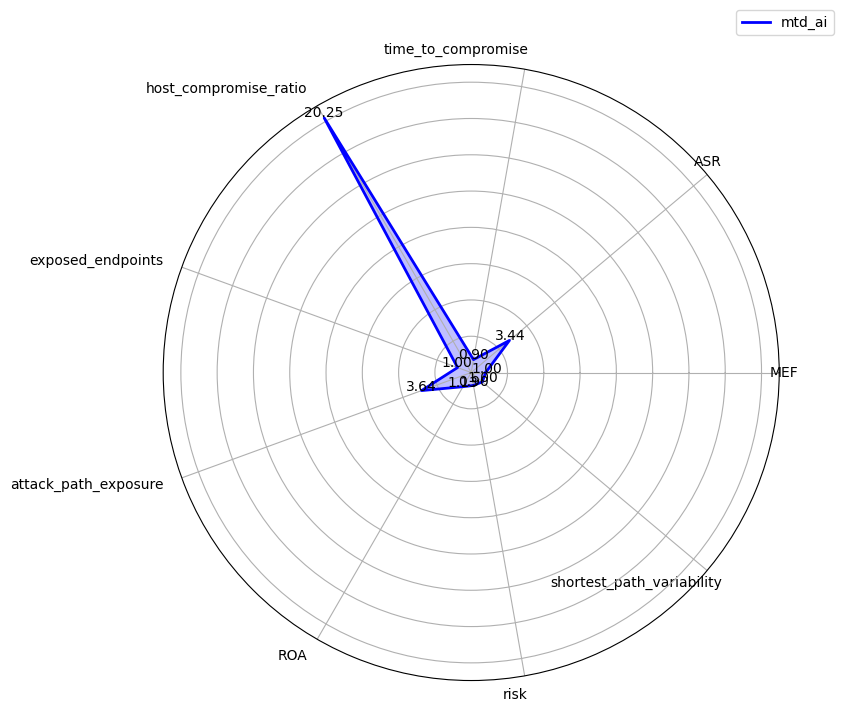

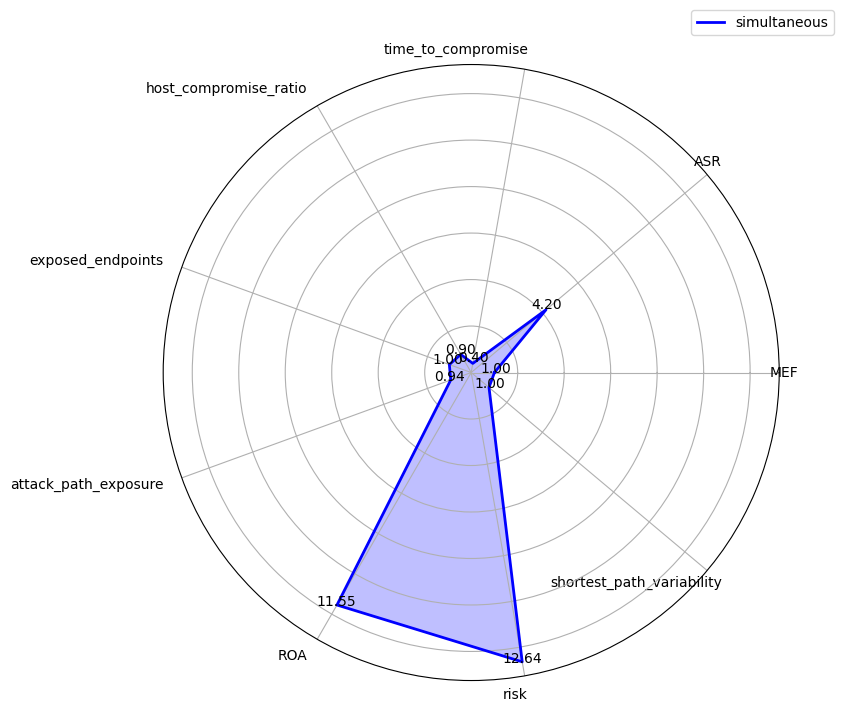

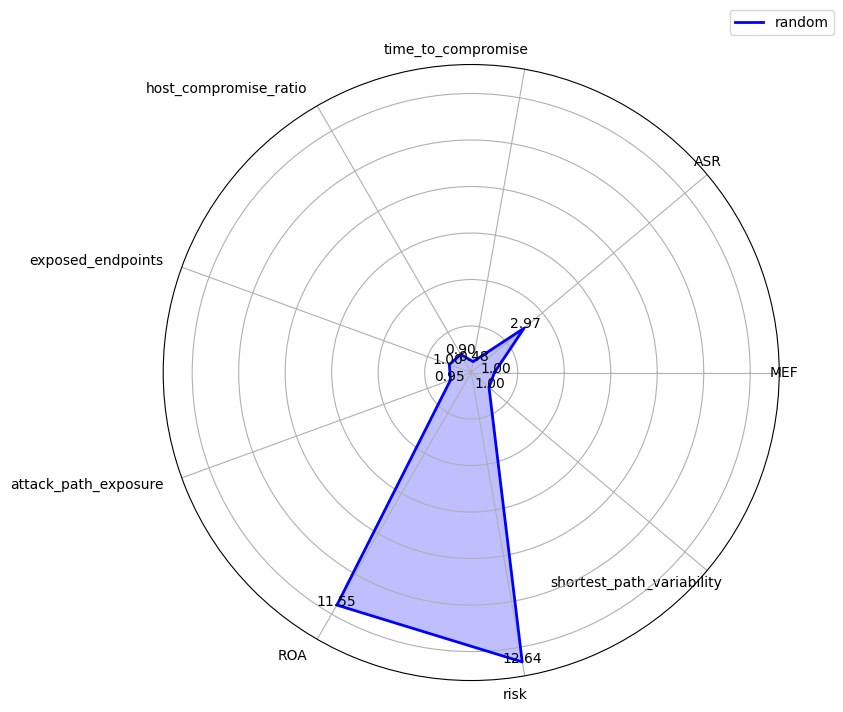

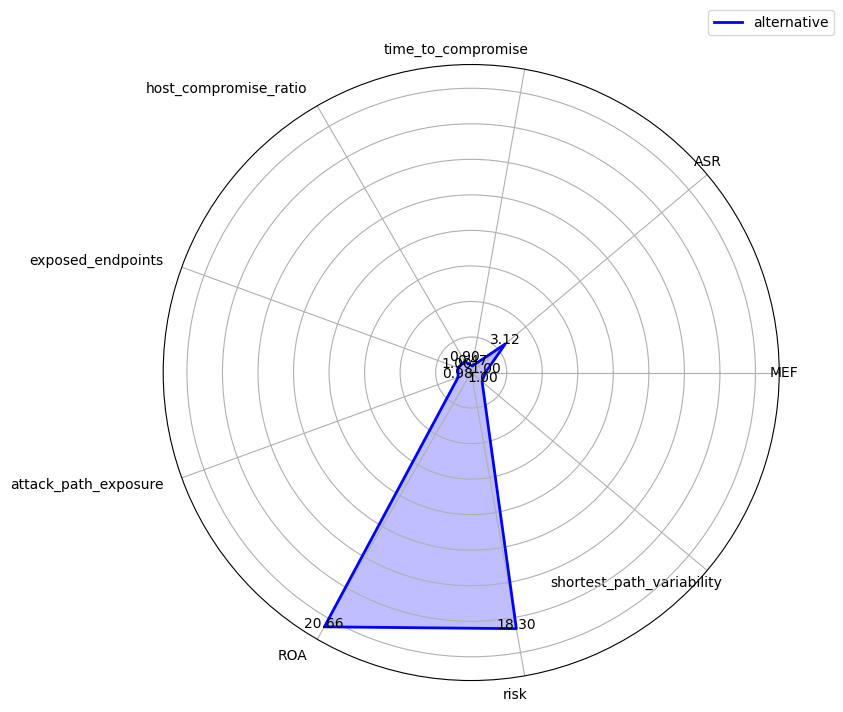

In [11]:
for scheme, data in results.items():
    radar.plot_single_radar(data, scheme, std_dev_values=None)
   